## Latency prediction under training inference co-working

### I. data preparation

In [2]:
import pandas as pd
import numpy as np
import os
import re
root ='./data'

def str2dict(file_name):
    
    arg_list = ['arch','workers', 'epochs','batch_size', 'image_size', 'device']
    config= file_name[0].split('+')
    train_args = re.findall(r'Train (.+)',config[0].strip())[0].split(' ')
    infer_args = re.findall(r'Infer (.+)',config[1].strip())[0].split(' ')
    train_dict ={}
    infer_dict ={}
    for arg in arg_list:
        for arg_val in train_args:
            if re.match(arg, arg_val):
                val = re.findall(arg+'_(.+)', arg_val)[0]
                train_dict[arg]=val
        for arg_val in infer_args:
            if re.match(arg, arg_val):
                val = re.findall(arg+'_(.+)', arg_val)[0]
                infer_dict[arg]=val
    return train_dict, infer_dict
# train_dict, infer_dict = str2dict(file_name)
# print(train_dict, infer_dict)

def dict_str2value(dict_old):
    model_list =  ['deeplab_v3', 'yolo_v5s', 'alexnet','densenet201','mobilenet_v2','resnet152','shufflenet_v2_x1_0', 'squeezenet1_0', 'vgg16']
    model_map = {}
    for i, model_name in enumerate(model_list): model_map[model_name] = i
    dict_new ={}
    for arg, val in dict_old.items():
        if arg=='arch':
            dict_new['arch']=model_map[val]
        elif arg == 'device':
            dict_new['device']= 1 if dict_old['device'] == 'cuda' else 0
        else: 
            dict_new[arg] = int(val)
    return dict_new

def dict_str2value_partial(dict_old):
    model_list =  ['deeplab_v3', 'yolo_v5s', 'alexnet','densenet201','mobilenet_v2','resnet152','shufflenet_v2_x1_0', 'squeezenet1_0', 'vgg16']
    model_map = {}
    for i, model_name in enumerate(model_list): model_map[model_name] = i
    dict_new ={}
    for arg, val in dict_old.items():
        if arg=='arch':
            dict_new['arch']=val
        elif arg == 'device':
            dict_new['device']= val
        else: 
            dict_new[arg] = int(val)
            dict_new[arg] = int(val)
    return dict_new

## columns to be added
train_col = ['arch', 'workers', 'epochs', 'batch_size', 'image_size', 'device']
infer_col = ['arch', 'workers', 'batch_size', 'image_size', 'device']
trn_col, inf_col =[], []
for col in train_col: trn_col.append('trn_'+col)
for col in infer_col: inf_col.append('inf_'+col)
add_col= trn_col+inf_col+['latency']
print(add_col)

['trn_arch', 'trn_workers', 'trn_epochs', 'trn_batch_size', 'trn_image_size', 'trn_device', 'inf_arch', 'inf_workers', 'inf_batch_size', 'inf_image_size', 'inf_device', 'latency']


In [16]:
## consolidate log's below folder's 

#logfile
log= pd.read_csv('./data/profiler_log_20230123200614.csv')


def parse_config(root, data_type, log_file):
    folder =os.path.join(root,'./',data_type)
    for file_name in os.listdir(folder):
        data =  pd.read_csv(os.path.join(folder,file_name))
    #     print(col)
        _file_name= re.findall(r'(.+)_20.+.csv', file_name)  # extract file name prefix
        train_dict, infer_dict = str2dict(_file_name)
        _train_dict = dict_str2value_partial(train_dict)  # change str to value, e.g. workers:'1'  to workers:1
        _infer_dict = dict_str2value_partial(infer_dict)
        record = log.where((log['train_configure']==str(_train_dict)) & \
                           (log['infer_configure']==str(_infer_dict))).dropna()
        result = record['result'].to_list()[0] # convert serial to list to string
        result = re.findall(r'{(.+)}', result)[0]  # extract string in { }
        latency = float(result.split(':')[1])
        train_dict_value = dict_str2value(train_dict)
        infer_dict_value = dict_str2value(infer_dict)
        values = list(train_dict_value.values())+list(infer_dict_value.values())+[latency]
        data_new= data.copy()
        for i, col in enumerate(add_col):
            for j in range(len(data)):  # repeatedly add 500 instances
                data_new[col]=values[i]
        data_new.to_csv(os.path.join(root,data_type+'_data.csv'), index_label=None, mode='a')
        print(f'Configure values of {data_type} : {values}.')

for data_type in ['train', 'val','test']:
    parse_config(root, data_type, log)
print('Data generated!')

Configure values of train : [8, 1, 3, 8, 224, 1, 4, 1, 1, 448, 1, 8.617367607892527].
Configure values of train : [5, 1, 3, 32, 224, 1, 4, 1, 1, 448, 1, 8.18356553074557].
Configure values of train : [3, 1, 3, 4, 224, 1, 4, 1, 1, 448, 1, 7.48066907860456].
Configure values of train : [6, 1, 3, 16, 224, 1, 3, 1, 1, 448, 1, 26.77643119200301].
Configure values of train : [7, 1, 3, 2, 224, 1, 3, 1, 1, 448, 1, 27.45291703357445].
Configure values of train : [2, 1, 3, 1, 224, 1, 2, 1, 1, 448, 1, 3.3249535613705024].
Configure values of train : [4, 1, 3, 64, 224, 1, 3, 1, 1, 448, 1, 26.76214380845985].
Configure values of train : [8, 1, 3, 64, 224, 1, 2, 1, 1, 448, 1, 3.552546609068063].
Configure values of train : [8, 1, 3, 1, 224, 1, 3, 1, 1, 448, 1, 26.967275904393727].
Configure values of train : [4, 1, 3, 1, 224, 1, 4, 1, 1, 448, 1, 6.558520704341547].
Configure values of train : [2, 1, 3, 1, 224, 1, 4, 1, 1, 448, 1, 7.217156633344023].
Configure values of train : [5, 1, 3, 1, 224, 1, 2

Configure values of train : [4, 1, 3, 8, 224, 1, 3, 1, 1, 448, 1, 26.807793488569246].
Configure values of train : [7, 1, 3, 8, 224, 1, 3, 1, 1, 448, 1, 26.824604271827614].
Configure values of train : [3, 1, 3, 4, 224, 1, 3, 1, 1, 448, 1, 26.75045947145595].
Configure values of train : [0, 1, 3, 1, 224, 1, 3, 1, 1, 448, 1, 26.771869154212418].
Configure values of train : [0, 1, 3, 1, 224, 1, 1, 1, 1, 448, 1, 25.464385237126535].
Configure values of train : [7, 1, 3, 64, 224, 1, 3, 1, 1, 448, 1, 26.482917982557268].
Configure values of train : [8, 1, 3, 2, 224, 1, 1, 1, 1, 448, 1, 29.46310041928657].
Configure values of train : [3, 1, 3, 32, 224, 1, 3, 1, 1, 448, 1, 27.297812248776633].
Configure values of train : [0, 1, 3, 4, 224, 1, 3, 1, 1, 448, 1, 26.39173870700294].
Configure values of train : [8, 1, 3, 4, 224, 1, 2, 1, 1, 448, 1, 3.425025881065215].
Configure values of train : [8, 1, 3, 16, 224, 1, 2, 1, 1, 448, 1, 3.519529190962818].
Configure values of train : [6, 1, 3, 2, 224,

Configure values of test : [6, 1, 3, 4, 224, 1, 2, 1, 1, 448, 1, 2.7300352308683196].
Configure values of test : [2, 1, 3, 256, 224, 1, 2, 1, 1, 448, 1, 2.822004654091595].
Configure values of test : [0, 1, 3, 4, 224, 1, 1, 1, 1, 448, 1, 25.476056914828913].
Configure values of test : [2, 1, 3, 4, 224, 1, 2, 1, 1, 448, 1, 2.924458459553681].
Configure values of test : [2, 1, 3, 8, 224, 1, 2, 1, 1, 448, 1, 2.9275447713087326].
Configure values of test : [6, 1, 3, 16, 224, 1, 1, 1, 1, 448, 1, 23.596322023843065].
Configure values of test : [6, 1, 3, 256, 224, 1, 4, 1, 1, 448, 1, 6.844241222007459].
Configure values of test : [7, 1, 3, 128, 224, 1, 4, 1, 1, 448, 1, 6.999055391209609].
Configure values of test : [7, 1, 3, 128, 224, 1, 2, 1, 1, 448, 1, 2.9122733306663253].
Configure values of test : [4, 1, 3, 64, 224, 1, 2, 1, 1, 448, 1, 2.968949907911629].
Configure values of test : [0, 1, 3, 8, 224, 1, 4, 1, 1, 448, 1, 7.654530101410442].
Configure values of test : [0, 1, 3, 4, 224, 1, 2,

## II. data analysis

In [3]:
import pandas as pd
import numpy as np
import os

## load data 
dataset_train = pd.read_csv(os.path.join(root, 'train_data.csv'), index_col = None)
dataset_train =  dataset_train.drop(['gpu_name', 'time_stamp','timestamp' ], axis=1)
dataset_val = pd.read_csv(os.path.join(root, 'val_data.csv'), index_col = None)#[:,2:] filter unnamed cols
dataset_val =  dataset_val.drop(['gpu_name', 'time_stamp','timestamp' ], axis=1) 
dataset_train= dataset_train[dataset_train['gpu_power']!='gpu_power'].dropna()  # drop off rows of column names
dataset_val= dataset_val[dataset_val['gpu_power']!='gpu_power'].dropna()
dataset_test = pd.read_csv(os.path.join(root, 'test_data.csv'), index_col = None)
dataset_test =  dataset_test.drop(['gpu_name', 'time_stamp','timestamp' ], axis=1)
dataset_test= dataset_test[dataset_test['gpu_power']!='gpu_power'].dropna()

# y_test = dataset_test.iloc[:,-1]
# x_test = dataset_test.iloc[:,:-1]
# y_train = dataset_train.iloc[:,-1]
# x_train = dataset_train.iloc[:,:-1]
# y_valid = dataset_val.iloc[:,-1]
# x_valid = dataset_val.iloc[:,:-1]

for col in dataset_val.columns: 
    dataset_val[col] = pd.to_numeric( dataset_val[col])
for col in dataset_train.columns: 
    dataset_train[col] = pd.to_numeric( dataset_train[col])
for col in dataset_test.columns: 
    dataset_test[col] = pd.to_numeric( dataset_test[col])
# view one instance   
print(dataset_val.columns)
print(dataset_train.iloc[0])

Index(['Unnamed: 0.1', 'Unnamed: 0', 'gpu_power', 'gpu_freq', 'gpu_mem_freq',
       'gpu_temp', 'gpu_util%', 'gpu_mem_util%', 'us', 'sy', 'ni', 'id', 'wa',
       'hi', 'si', 'st', 'cpu0_freq', 'cpu1_freq', 'cpu2_freq', 'cpu3_freq',
       'cpu4_freq', 'cpu5_freq', 'cpu6_freq', 'cpu7_freq', 'cpu8_freq',
       'cpu9_freq', 'cpu10_freq', 'cpu11_freq', 'cpu12_freq', 'cpu13_freq',
       'cpu14_freq', 'cpu15_freq', 'trn_arch', 'trn_workers', 'trn_epochs',
       'trn_batch_size', 'trn_image_size', 'trn_device', 'inf_arch',
       'inf_workers', 'inf_batch_size', 'inf_image_size', 'inf_device',
       'latency'],
      dtype='object')
Unnamed: 0.1      0.000000e+00
Unnamed: 0        0.000000e+00
gpu_power         1.100800e+02
gpu_freq          1.710000e+03
gpu_mem_freq      9.251000e+03
gpu_temp          4.500000e+01
gpu_util%         7.000000e+00
gpu_mem_util%     0.000000e+00
us                3.700000e+01
sy                4.500000e+00
ni                0.000000e+00
id                5

In [3]:
dataset_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78000 entries, 0 to 78154
Data columns (total 44 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0.1    78000 non-null  float64
 1   Unnamed: 0      78000 non-null  int64  
 2   gpu_power       78000 non-null  float64
 3   gpu_freq        78000 non-null  int64  
 4   gpu_mem_freq    78000 non-null  int64  
 5   gpu_temp        78000 non-null  int64  
 6   gpu_util%       78000 non-null  int64  
 7   gpu_mem_util%   78000 non-null  int64  
 8   us              78000 non-null  float64
 9   sy              78000 non-null  float64
 10  ni              78000 non-null  float64
 11  id              78000 non-null  float64
 12  wa              78000 non-null  float64
 13  hi              78000 non-null  float64
 14  si              78000 non-null  float64
 15  st              78000 non-null  float64
 16  cpu0_freq       78000 non-null  int64  
 17  cpu1_freq       78000 non-null 

## Predict with XGBoost
    -  https://xgboost.readthedocs.io/en/stable/parameter.html

In [24]:
y_train

0         8.617368
1         8.617368
2         8.617368
3         8.617368
4         8.617368
           ...    
78150    26.835701
78151    26.835701
78152    26.835701
78153    26.835701
78154    26.835701
Name: latency, Length: 78000, dtype: float64

[0]	train-rmse:20.66784+0.01462	train-mae:227993114483097.59375+2518548485617.64746	test-rmse:20.66781+0.05884	test-mae:227993124549427.18750+10074218206736.67578
[10]	train-rmse:18.71297+0.02639	train-mae:227993114483097.59375+2518548485617.64746	test-rmse:18.71248+0.04568	test-mae:227993124549427.18750+10074218206736.67578
[20]	train-rmse:16.94108+0.02090	train-mae:227993114483097.59375+2518548485617.64746	test-rmse:16.94081+0.05251	test-mae:227993124549427.18750+10074218206736.67578
[30]	train-rmse:15.32814+0.02047	train-mae:227993114483097.59375+2518548485617.64746	test-rmse:15.32798+0.04741	test-mae:227993124549427.18750+10074218206736.67578
[40]	train-rmse:13.88466+0.02873	train-mae:227993114483097.59375+2518548485617.64746	test-rmse:13.88445+0.03509	test-mae:227993124549427.18750+10074218206736.67578
[50]	train-rmse:12.56259+0.02573	train-mae:227993114483097.59375+2518548485617.64746	test-rmse:12.56243+0.03344	test-mae:227993124549427.18750+10074218206736.67578
[60]	train-rmse:1

[510]	train-rmse:0.36076+0.00781	train-mae:111085017366528.00000+3939663253532.44629	test-rmse:0.36622+0.01861	test-mae:112736289685504.00000+9596789552096.55078
[520]	train-rmse:0.35232+0.00785	train-mae:107355341586432.00000+3430601561744.39111	test-rmse:0.35793+0.01877	test-mae:109044379418624.00000+10328829772985.31836
[530]	train-rmse:0.34383+0.00764	train-mae:103720623171174.40625+3299807262441.77637	test-rmse:0.34960+0.01818	test-mae:105460212432896.00000+10478945833656.00977
[540]	train-rmse:0.33631+0.00818	train-mae:99290666395238.40625+3973107671649.18359	test-rmse:0.34213+0.01852	test-mae:101135237408358.40625+10264552329377.21484
[550]	train-rmse:0.32770+0.00776	train-mae:95472588108595.20312+4189320971082.34180	test-rmse:0.33364+0.01774	test-mae:97303926931456.00000+10225112742847.42578
[560]	train-rmse:0.32105+0.00630	train-mae:91900155107737.59375+4633184884213.92090	test-rmse:0.32694+0.01632	test-mae:93780164634214.40625+10049144503225.76562
[570]	train-rmse:0.31529+0.0

Text(0.5, 1.0, 'Rounds of training')

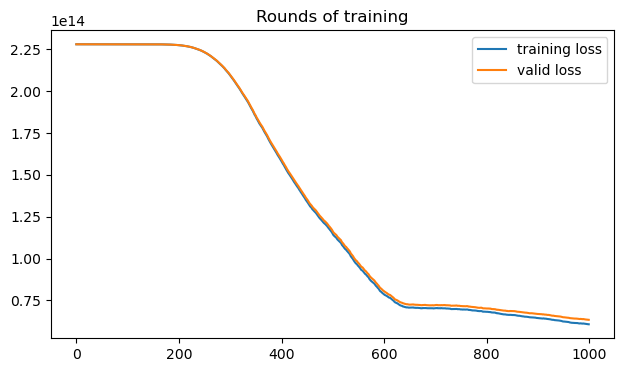

In [207]:
## Use XGB to predcit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
from sklearn.metrics import mean_absolute_error,make_scorer
from xgboost import XGBRegressor

y_train = dataset_train.iloc[:,-1]
x_train = dataset_train.iloc[:,:-1]
y_valid = dataset_val.iloc[:,-1]
x_valid = dataset_val.iloc[:,:-1]

def xg_eval_mae(yhat,dtrain):
    y=dtrain.get_label()
    return 'mae',mean_absolute_error(np.exp(y),np.exp(yhat))

dtrain=xgb.DMatrix(x_train,y_train)

xgb_params={
    'seed':0,
    'eta':0.01,
    'colsample_bytree':0.5,
#     'silent':1,  #old version
    'verbosity':0,
    'subsample':0.5,
    'objective':'reg:linear',  
    'max_depth':5,  #5
    'min_child_weight':3
}

## cross validate to tune parameters
bst_cv=xgb.cv(xgb_params,dtrain,
              
              num_boost_round=1000,
              nfold=5,seed=3,
              feval=xg_eval_mae,
              maximize=False,
              early_stopping_rounds=100,
              verbose_eval=10)
# print('CV score:',bst_cv.iloc[-1,:]['test-mae-mean'])

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(bst_cv[['train-mae-mean','test-mae-mean']])
plt.legend(['training loss','valid loss'])
plt.title('Rounds of training')

# plt.subplot(1,2,2)
# plt.plot(bst_cv.iloc[60:80][['train-mae-mean','test-mae-mean']])
# plt.legend(['training loss','valid loss'])
# plt.show()


In [201]:
from xgboost import XGBRegressor
## prediction
y_train = dataset_train.iloc[:,-1]
x_train = dataset_train.iloc[:,:-1]
y_test = dataset_test.iloc[:,-1]
x_test = dataset_test.iloc[:,:-1]

# other_params = {'learning_rate': 0.05, 'n_estimators': 80, 'max_depth': 5, \
#                 'min_child_weight': 1, 'seed': 0, 'subsample': 0.8, 'colsample_bytree': 0.8,\
#                 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
# model = XGBRegressor(XGBRegressor(objective='reg:squarederror',**other_params)).fit(x_train, y_train)

model = XGBRegressor( seed=0, eta=0.01, colsample_bytree=0.2, subsample=0.8,  booster = 'gbtree',\
                     gamma= 0, reg_lambda= 2000,reg_alpha = 0,\
    objective='reg:squarederror', max_depth= 5, min_child_weight= 5,n_estimators=500)  #n_estimators: num_boost_round

model.fit(x_train,y_train)
prd = model.predict(x_test)
y_test = np.array(y_test)

rmse= np.sqrt(np.sum((y_test-prd)**2)/len(y_test))
mae = np.sum(np.abs(y_test-prd))/len(y_test)
latency = (time.time()-start)/len(y_test)*1000

print(f' RMSE: {rmse}, MAE: {mae}')
print(f'Latency for predicting each instance: {latency} ms.)

 RMSE: 3.098062762747909, MAE: 1.9345986454687216


In [202]:
import time
start = time.time()
prd = model.predict(x_test)
y_test = np.array(y_test)
latency = (time.time()-start)/len(y_test)*1000
latency

0.0028461197675284694

In [208]:
prd[0:200]

array([8.34862  , 7.106043 , 8.118373 , 8.079828 , 8.257298 , 9.251617 ,
       9.372    , 8.99288  , 8.474922 , 9.11948  , 9.058959 , 9.066212 ,
       8.155584 , 8.018817 , 9.02638  , 8.501279 , 8.275396 , 8.274997 ,
       8.842968 , 9.184693 , 9.154252 , 8.129358 , 9.288066 , 8.722616 ,
       8.799622 , 8.580982 , 8.15195  , 9.156896 , 8.273625 , 8.781353 ,
       8.819634 , 9.030599 , 8.351975 , 8.842837 , 9.093483 , 8.522842 ,
       8.735254 , 8.840647 , 8.778857 , 8.823894 , 9.124349 , 8.937662 ,
       8.7630625, 9.037081 , 8.922672 , 8.390778 , 9.33006  , 8.915077 ,
       9.203065 , 8.920647 , 8.676243 , 9.20818  , 9.136644 , 7.999183 ,
       8.87598  , 8.778664 , 8.485142 , 9.095781 , 9.439166 , 8.993362 ,
       8.316894 , 9.16591  , 8.628298 , 9.259952 , 9.564245 , 8.796749 ,
       7.889418 , 8.816114 , 8.42126  , 8.8521385, 8.920844 , 8.810765 ,
       8.872787 , 9.01958  , 8.138006 , 8.435204 , 9.11433  , 8.915328 ,
       8.827297 , 8.758042 , 8.488775 , 9.058444 , 

In [209]:
y_test[:200]

array([6.7475108, 6.7475108, 6.7475108, 6.7475108, 6.7475108, 6.7475108,
       6.7475108, 6.7475108, 6.7475108, 6.7475108, 6.7475108, 6.7475108,
       6.7475108, 6.7475108, 6.7475108, 6.7475108, 6.7475108, 6.7475108,
       6.7475108, 6.7475108, 6.7475108, 6.7475108, 6.7475108, 6.7475108,
       6.7475108, 6.7475108, 6.7475108, 6.7475108, 6.7475108, 6.7475108,
       6.7475108, 6.7475108, 6.7475108, 6.7475108, 6.7475108, 6.7475108,
       6.7475108, 6.7475108, 6.7475108, 6.7475108, 6.7475108, 6.7475108,
       6.7475108, 6.7475108, 6.7475108, 6.7475108, 6.7475108, 6.7475108,
       6.7475108, 6.7475108, 6.7475108, 6.7475108, 6.7475108, 6.7475108,
       6.7475108, 6.7475108, 6.7475108, 6.7475108, 6.7475108, 6.7475108,
       6.7475108, 6.7475108, 6.7475108, 6.7475108, 6.7475108, 6.7475108,
       6.7475108, 6.7475108, 6.7475108, 6.7475108, 6.7475108, 6.7475108,
       6.7475108, 6.7475108, 6.7475108, 6.7475108, 6.7475108, 6.7475108,
       6.7475108, 6.7475108, 6.7475108, 6.7475108, 

## predict with MPL

Epoch 1/200
9750/9750 [==============================] - 28s 3ms/step - loss: 82.3386 - val_loss: 34.0811
Epoch 2/200
9750/9750 [==============================] - 27s 3ms/step - loss: 52.2922 - val_loss: 43.9989
Epoch 3/200
9750/9750 [==============================] - 27s 3ms/step - loss: 50.0423 - val_loss: 34.0562
Epoch 4/200
9750/9750 [==============================] - 27s 3ms/step - loss: 48.8389 - val_loss: 46.0057
Epoch 5/200
9750/9750 [==============================] - 27s 3ms/step - loss: 48.6001 - val_loss: 38.7507
Epoch 6/200
9750/9750 [==============================] - 27s 3ms/step - loss: 47.2428 - val_loss: 30.2692
Epoch 7/200
9750/9750 [==============================] - 27s 3ms/step - loss: 46.8320 - val_loss: 40.3160
Epoch 8/200
9750/9750 [==============================] - 27s 3ms/step - loss: 46.5591 - val_loss: 30.9953
Epoch 9/200
9750/9750 [==============================] - 27s 3ms/step - loss: 46.0435 - val_loss: 40.0882
Epoch 10/200
9750/9750 [======================

9750/9750 [==============================] - 28s 3ms/step - loss: 43.7221 - val_loss: 41.2194
Epoch 154/200
9750/9750 [==============================] - 27s 3ms/step - loss: 43.4343 - val_loss: 41.6615
Epoch 155/200
9750/9750 [==============================] - 27s 3ms/step - loss: 42.9914 - val_loss: 38.5091
Epoch 156/200
9750/9750 [==============================] - 27s 3ms/step - loss: 43.4528 - val_loss: 30.1628
Epoch 157/200
9750/9750 [==============================] - 28s 3ms/step - loss: 43.4894 - val_loss: 41.4107
Epoch 158/200
9750/9750 [==============================] - 27s 3ms/step - loss: 43.3789 - val_loss: 34.2096
Epoch 159/200
9750/9750 [==============================] - 27s 3ms/step - loss: 43.5867 - val_loss: 40.8264
Epoch 160/200
9750/9750 [==============================] - 28s 3ms/step - loss: 43.6301 - val_loss: 37.3219
Epoch 161/200
9750/9750 [==============================] - 28s 3ms/step - loss: 42.9320 - val_loss: 39.4001
Epoch 162/200
9750/9750 [=================

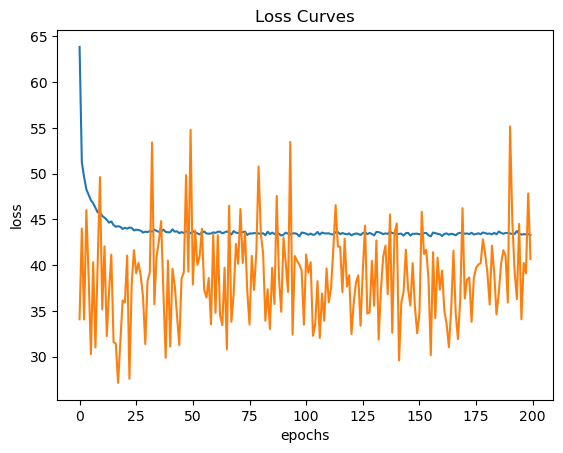

In [95]:
#coding:utf-8
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

class data_utils():
    def __init__(self):
        pass

    def minmax_scale(self,dataset):

        min_max_scaler = MinMaxScaler()
        min_max_scaler.fit(dataset)
        dataset = min_max_scaler.transform(dataset)
        return dataset
 
    def minmax_scale_inverse(self,y_valid,y_new):

        min_max_scaler = MinMaxScaler()
        min_max_scaler.fit(y_valid)
        y_new_TURE = min_max_scaler.inverse_transform(y_new)
        return y_new_TURE
    
    def PCA(self, X, k, axis=1):  # feature in rows axis =0, in cols axis =1, X in np.array formate
        if axis==0:  #features by rows
            n = X.shape[0]
            mean = np.mean(X, axis = 0).reshape(1,-1) # features number X data number 
            Xm = (X- mean)
            COV =  Xm @ Xm.T/(n-1)
            eig_value, eig_vector = np.linalg.eig(COV) 
            index = np.argsort(-1*eig_value) # rank from the largest value to the smallest one， descend
            P = eig_vector[:,index[0:k]]
            return P.T @ Xm
        
        else:  #axis == 1, features by cols
    #         X=dataframe.values
#             n = np.array(X).shape[1]
            n = X.shape[0]
            mean = np.mean(X, axis = 1).reshape(-1,1) # features number X data number 
            Xm = (X- mean)
            COV =  Xm.T@Xm/(n-1)
            eig_value, eig_vector = np.linalg.eig(COV) 
            index = np.argsort(-1*eig_value) # rank from the largest value to the smallest one， descend
            P = eig_vector[:,index[0:k]]
            return Xm@P


class neural_network():
    def __init__(self,epochs= 200,batch_size=8,verbose=1,loss='mse',optimizer='adam'):
        self.epochs = epochs          
        self.batch_size = batch_size  
        self.verbose = verbose        
        self.loss = loss              
        self.optimizer = optimizer    

    def train_nn(self,x_train, y_train,x_valid, y_valid):

        model = Sequential()  
        model.add(Dense(units = 32,                      
                        activation='linear',             
                        input_shape=(x_train.shape[1],)  
                        ))
        model.add(Dropout(0.2))  
        
        model.add(Dense(units = 32,                      
                activation='linear',             
                input_shape=(64,)  
                ))
        model.add(Dropout(0.2))  
        
        model.add(Dense(units = 32,                      
        activation='linear',             
        input_shape=(32,)  
        ))
        model.add(Dropout(0.2))  
        
        model.add(Dense(units = 16,                      
        activation='linear',             
        input_shape=(32,)  
        ))        
        model.add(Dropout(0.2))  
        
        model.add(Dense(units = 1,  activation='linear')) 
        model.compile(loss=self.loss,optimizer=self.optimizer,) 
        history = model.fit(x_train, y_train,  epochs=self.epochs, 
                            batch_size=self.batch_size, 
                            verbose=self.verbose, 
                            validation_data = (x_valid, y_valid)) 
 
        plt.title('Loss Curves')
        plt.ylabel('loss')
        plt.xlabel('epochs')
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.show()

        model.save('nn_model.h5') 

    def predict_nn(self,x_test):

        model = load_model('nn_model.h5')
        y_new = model.predict(x_test)
        return y_new

def main(dataset_train, dataset_val):

    du = data_utils()
    nn = neural_network()     

    y_train = dataset_train.iloc[:,-1].to_numpy().reshape(-1, 1)
    x_train = dataset_train.iloc[:,:-1].to_numpy()
    y_valid = dataset_val.iloc[:,-1].to_numpy().reshape(-1, 1)
    x_valid = dataset_val.iloc[:,:-1].to_numpy()
    

    _x_train = du.minmax_scale(x_train)   
#     y_train = du.minmax_scale(y_train)   
    _x_valid = du.minmax_scale(x_valid)   
#     y_valid = du.minmax_scale(y_valid)    

#     K= 4
#     _x_train=du.PCA(_x_train, K, axis= 1)
#     _x_train=pd.DataFrame(_x_train, columns= np.arange(K), index= None)
    
#     _x_valid=du.PCA(_x_valid, K, axis= 1)
#     _x_valid=pd.DataFrame(_x_valid, columns= np.arange(K), index= None)

    
    nn.train_nn(_x_train, y_train,_x_valid, y_valid) 
#     pre_new = nn.predict_nn(_x_valid)               
#     pre_new = du.minmax_scale_inverse(y_valid, pre_new) 

if __name__ == "__main__":
    main(dataset_train, dataset_val)

### backup

In [18]:
## get inference time
import pandas as pd
log= pd.read_csv('./data/profiler_log_20230123200614.csv')
log

,Unnamed: 0,time_frame,train_configure,infer_configure,status,result
0,1,1.674091e+09,"{'arch': 'deeplab_v3', 'workers': 1, 'epochs':...","{'arch': 'yolo_v5', 'workers': 1, 'batch_size'...",Sucess,{'latency': 16.18007766597196}
1,2,1.674092e+09,"{'arch': 'deeplab_v3', 'workers': 1, 'epochs':...","{'arch': 'yolo_v5', 'workers': 1, 'batch_size'...",Sucess,{'latency': 15.969569237430791}
2,3,1.674092e+09,"{'arch': 'deeplab_v3', 'workers': 1, 'epochs':...","{'arch': 'yolo_v5', 'workers': 1, 'batch_size'...",Sucess,{'latency': 16.01557815458632}
3,4,1.674092e+09,"{'arch': 'deeplab_v3', 'workers': 1, 'epochs':...","{'arch': 'yolo_v5', 'workers': 1, 'batch_size'...",Fail,"Traceback (most recent call last):\n File ""/h..."
4,5,1.674093e+09,"{'arch': 'alexnet', 'workers': 1, 'epochs': 3,...","{'arch': 'yolo_v5', 'workers': 1, 'batch_size'...",Sucess,{'latency': 14.060524985394178}
...,...,...,...,...,...,...
229,230,1.674110e+09,"{'arch': 'vgg16', 'workers': 1, 'epochs': 3, '...","{'arch': 'vgg16', 'workers': 1, 'batch_size': ...",Fail,"Traceback (most recent call last):\n File ""/h..."
230,231,1.674110e+09,"{'arch': 'vgg16', 'workers': 1, 'epochs': 3, '...","{'arch': 'vgg16', 'workers': 1, 'batch_size': ...",Fail,"Traceback (most recent call last):\n File ""/h..."
231,232,1.674110e+09,"{'arch': 'vgg16', 'workers': 1, 'epochs': 3, '...","{'arch': 'vgg16', 'workers': 1, 'batch_size': ...",Fail,"Traceback (most recent call last):\n File ""/h..."
232,233,1.674110e+09,"{'arch': 'vgg16', 'workers': 1, 'epochs': 3, '...","{'arch': 'vgg16', 'workers': 1, 'batch_size': ...",Fail,"Traceback (most recent call last):\n File ""/h..."


In [27]:
a="{'arch': 'alexnet', 'workers': 1, 'epochs': 3, 'batch_size': 128, 'image_size': 224, 'device': 'cuda'}"
b="{'arch': 'yolo_v5', 'workers': 1, 'batch_size': 1, 'image_size': 224, 'device': 'cuda'}"

In [ ]:
{'arch': 'alexnet', 'workers': 1, 'epochs': 3, 'batch_size': 1024, 'image_size': 224, 'device': 'cuda'}

In [96]:
## evaluate
dataset_test = pd.read_csv(os.path.join(root, 'test_data.csv'), index_col = None)
dataset_test =  dataset_test.drop(['gpu_name', 'time_stamp','timestamp' ], axis=1)
dataset_test= dataset_test[dataset_test['gpu_power']!='gpu_power'].dropna()
y_test = dataset_test.iloc[:,-1]
x_test = dataset_test.iloc[:,:-1]
for col in dataset_test.columns: 
    dataset_test[col] = pd.to_numeric( dataset_test[col])
    
du = data_utils()
nn = neural_network()
y_test = dataset_test.iloc[:,-1].to_numpy().reshape(-1, 1)
x_test = dataset_test.iloc[:,:-1].to_numpy()
x_test = du.minmax_scale(x_test)   

# K= 4
# x_test=du.PCA(x_test, K, axis= 1)
# x_test=pd.DataFrame(x_test, columns= np.arange(K), index= None)

prd_test = nn.predict_nn(x_test)[:,0]
y_test = y_test[:,0]

rmse= np.sqrt(np.sum((y_test-prd_test)**2)/len(y_test))
mae = np.sum(np.abs(y_test-prd_test))/len(y_test)

print(f' MSE: {rmse}, MAE: {mae}')

 MSE: 7.794252218654664, MAE: 6.536998469680111
